In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [3]:
data=pd.read_csv('/kaggle/input/pokemon-images-and-types/pokemon.csv')
data

,Name,Type1,Type2,Evolution
0,bulbasaur,Grass,Poison,ivysaur
1,ivysaur,Grass,Poison,venusaur
2,venusaur,Grass,Poison,NaN
3,charmander,Fire,NaN,charmeleon
4,charmeleon,Fire,NaN,charizard
...,...,...,...,...
804,stakataka,Rock,Steel,NaN
805,blacephalon,Fire,Ghost,NaN
806,zeraora,Electric,NaN,NaN
807,meltan,Steel,NaN,NaN


In [4]:
data.value_counts('Type1')

Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: count, dtype: int64

In [5]:
data=data[data.Type1.isin(['Water','Grass','Fire'])][['Name','Type1']]
data

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire
...,...,...
778,bruxish,Water
786,tapu-bulu,Grass
787,tapu-fini,Water
797,kartana,Grass


In [6]:
print('Data shape',data.shape)
print('Number of unique names',data.Name.nunique())

Data shape (245, 2)
Number of unique names 245


In [7]:
import os
import pandas as pd
import cv2

image_df=[]

path_start='/kaggle/input/pokemon-images-and-types/images'
for filename in os.listdir(path_start):
    if filename.endswith(".png"):
        image_name = filename.split('.')[0]  
        
        image = cv2.imread(os.path.join(path_start, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
#         image_df=image_df.append({'Name':image_name,'img':np.array(image)},ignore_index=True)
#         image_df=pd.concat
        image_df.append({'Name':image_name,'img':np.array(image)})

image_df=pd.DataFrame(image_df)

In [8]:
data=data.merge(image_df,how='inner', on='Name')

In [9]:
data.value_counts('Type1')

Type1
Water    114
Grass     78
Fire      53
Name: count, dtype: int64

In [10]:
data.loc[0].img.shape

(120, 120, 3)

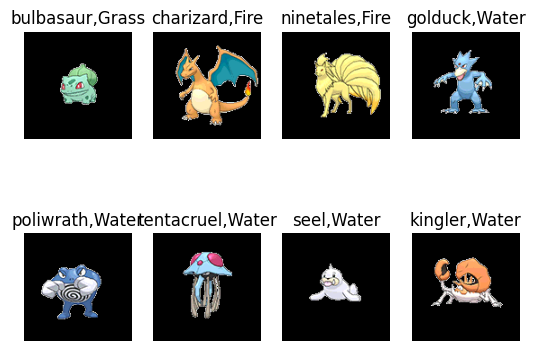

In [11]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(data.loc[i*5].img)
    plt.title(f"{data.loc[i*5].Name},{data.loc[i*5].Type1}")
    plt.axis('off')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X=np.array(data['img'].tolist(), dtype = np.float32)/255.0
y=data['Type1']

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


augmented_images = []
augmented_labels = []


for i in range(len(X)):
    image = X[i]
    label = y[i]
    image = np.expand_dims(image, axis=0)
    label = np.array([label])
    augmented_images_batch, augmented_labels_batch = [], []
    j=0
    for x_batch, y_batch in datagen.flow(image, label, batch_size=4):
        augmented_images_batch.extend(x_batch)
        augmented_labels_batch.extend(y_batch)
        j+=1
        if j>3:
            break
    augmented_images.extend(augmented_images_batch)
    augmented_labels.extend(augmented_labels_batch)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


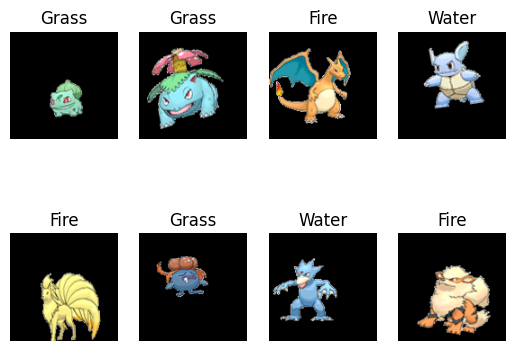

In [14]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(augmented_images[i*10])
    plt.title(f"{augmented_labels[i*10]}")
    plt.axis('off')
plt.show()

In [15]:
labels_dict={'Water': 0, 'Grass': 1, 'Fire': 2}


y_final = []
for yi in y:
    y_final.append(labels_dict[yi])


X_train, X_test, y_train, y_test=train_test_split(X,y_final, test_size=.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(120, 120, 3), 
                  kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,862,659 (10.92 MB)

 Trainable params: 2,862,659 (10.92 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
histor=cnn.fit(X_train, y_train, epochs=20, validation_data=(X_test,y_test))

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 449ms/step - accuracy: 0.3462 - loss: 2.5659 - val_accuracy: 0.5102 - val_loss: 2.2950
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.5169 - loss: 2.2492 - val_accuracy: 0.4694 - val_loss: 2.1100
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 388ms/step - accuracy: 0.4684 - loss: 2.0341 - val_accuracy: 0.4694 - val_loss: 1.8991
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.4650 - loss: 1.8411 - val_accuracy: 0.5306 - val_loss: 1.7117
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - accuracy: 0.5642 - loss: 1.5964 - val_accuracy: 0.6531 - val_loss: 1.4299
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.6403 - loss: 1.3648 - val_accuracy: 0.6939 - val_loss: 1.2994
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.7424 - loss: 1.1771 - val_accuracy: 0.6735 - val_loss: 1.2690
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - accuracy: 0.6873 - loss: 1.1716 - val_accuracy: 0.6939 - val_loss:

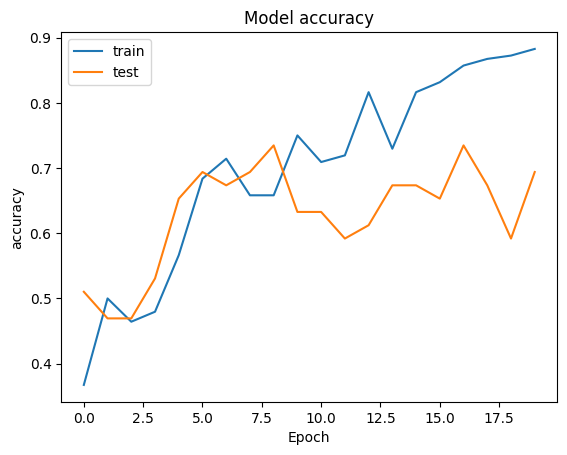

In [18]:
plt.plot(histor.history['accuracy'])
plt.plot(histor.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras import layers, models

# Define the input shape
input_shape = (224, 224, 3)

# ResNet Model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_model.trainable = False  # Freeze the layers

resnet = models.Sequential([
    layers.Input(shape=input_shape),
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# MobileNet Model
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenet_model.trainable = False  # Freeze the layers

mobilenet = models.Sequential([
    layers.Input(shape=input_shape),
    mobilenet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Compile models
resnet.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
mobilenet.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Display model summaries
resnet.summary()
mobilenet.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)